# PyTube 

### Uzair

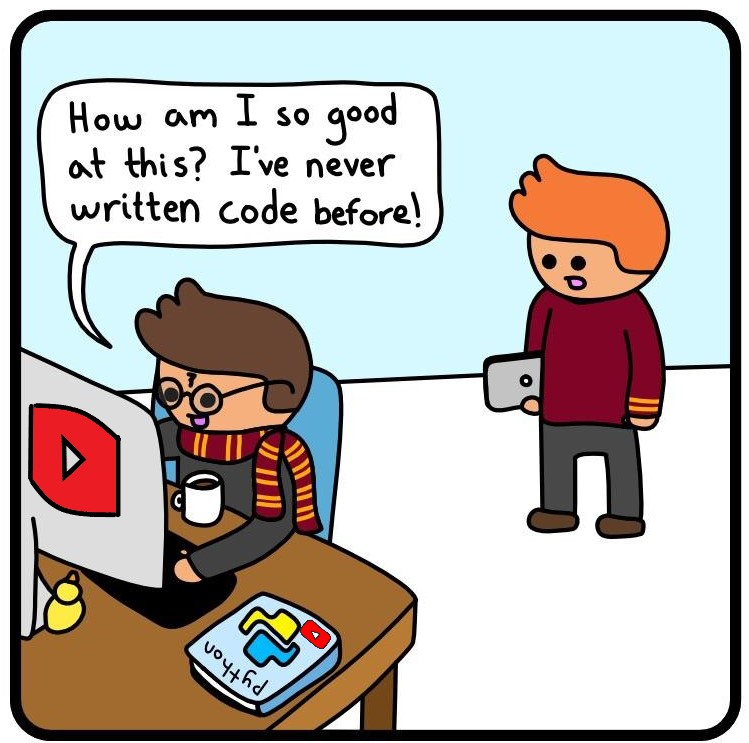

# Introduction:
YouTube today is one of the largest video streaming platforms in the world and yet the way its algorithm handles the content is still quite unclear. We all have had these questions while YouTubing on why certain videos are on the trending list while others are not. This question is especially important for YouTube content creators. YouTube Creators are individuals who produce content for the platform. This is a unique model that empowers Creators to earn money through placed advertising, merchandise sales, and subscriptions.

In this project, we try to understand how YouTube ranks its trending videos. We also aim to provide insights for Content Creators on the kind of content to provide in order to increase their probability of making their video trend and in turn generate more revenue.
 
We try to address the above conundrum by analyzing the following questions :
 
- Impact of likes, views, comment Count, and Video Duration. 
- When to publish a video to increase the probability of making it trend.
- Understand the impact of tags, and how this could be used to increase the visibility of the video.
- Video Titles: To find if there are certain words in the title which increase the clicks on videos.
- We try to understand the impact of geography, culture, globalization, and economy on trending videos.

 Watch out! We could be giving you the secret sauce to make your next video go viral.
 
### Data Source and Description:
The Data used in this analysis was extracted from YouTube using the YouTube API from 11 countries.
Script was run on '9th November' to generate data on the Trending Videos. <br>It consists of 20 columns from various countries like US, Brazil, India, Russia, Canada, Great Britain, France, Germany, Korea, Japan and Mexico which are video_id, title, publishedAt, channelId, channelTitle, categoryId, trending_date, tags, view_count, likes, dislikes, comment_count, thumbnail_link, comments_disabled, ratings_disabled, description, videoresolution, videoduration, videoprojected and videoliscensed with approximately 2200 data rows of all countries combined.<br> We combined various data points of all the countries into a single sheet and added a country column to identify which country the video originated from. We sourced the data using the Google API. This file is self sufficient and can be used to generate the excel files into an output folder.
  

# Choice for Heavier Grading on Data Analysis:
Although we have spent a considerable amount of effort in data acquiring tasks-learning to use YouTube API calls and going through the content-heavy documentation, **we think our project is data analysis heavy**. We have spent more time on the analysis as our main aim was to extract useful insights for content creators, by answering multiple questions mentioned above. Considering this, we have come with 6 visualizations to support our analysis.



# Data Analysis:

## YouTube Trending Video Analysis

For Youtube Analysis, we would require the following libraries. So we start by importing them.
To use the Google API client for youtube, we need to run the below command in the cmd prompt/ mac terminal
`pip install google-api-python-client`. 
Additionally, since we are using Vader, we also need to run `pip install vaderSentiment`.

- `import numpy`
- `import pandas`
- `import datetime`
- `import re`
- `import seaborn`
- `import os`
- `from dateutil.parser import parse`
- `from googleapiclient.discovery import build`
- `import nltk`
- `from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator`
- `import plotly.graph_objects as go`
- `from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer`


**Note:** We are only using the data we have fetched on 9th November, so we would not need to re-run the Get API code.

In [1]:
import requests, sys, time, os, argparse
import numpy as np 
import pandas as pd 
import datetime as dt
import re

from collections import Counter
from os import path
from PIL import Image


from dateutil.parser import parse
from googleapiclient.discovery import build

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.text import Text

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
#nltk.download()
import nltk
from textblob import TextBlob
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import imageio
from IPython.display import Image, HTML

## Youtube API Key:

After creating a Google account, we have to create a Google API key for our use only. To ensure the security of the API key, we will not use it directly in the code. <br> We create a bin file, store the API key inside it, and then fetch the API key from the code.<br> For ease of access, we have added the token key for your reference.

In [2]:
api_key = ""

#Use below code for securing the api_key

# get the api_file.bin which contains the api key 
# with open("api_file.bin",encoding="utf-8") as binary_file:
#     apkey = binary_file.read()
#     api_key = str(apkey)
    
# We use the build fuction to create a service object. It takes Api name and the version as arguments along with the apikey
yt =  build('youtube','v3',developerKey=api_key)

## Trends or Countries to Choose:

Here our aim is to get specific features from the API for a set of countries which can be changed as per requirement. Combining the names into a header variable so as to later on add the column names to the dataframes/ csv files which ever we choose.

In [3]:
# the max rows returned by the api is 50 so we set the variable to 50
max_res = 50
country_codes =['US','GB','IN','DE','CA','FR','KR','RU','JP','BR','MX']


output_dir = 'output/'
features_snippet =  ["title","publishedAt","channelId","channelTitle","categoryId"]

header = ["video_id"] + features_snippet + ["trending_date", "tags", "view_count", "likes", "dislikes",
                                            "comment_count", "thumbnail_link", "comments_disabled",
                                            "ratings_disabled", "description","videoresolution","videoduration","videoprojected","videoliscensed"]
       

## Basic Cleaning of the API & Tag Management
After some trial and error we found that generally we find issues like `\n` and quotes which can later on cause issues in the code as both can affect python code so we create a function to replace these features.<br>Youtube videos have many tags under thier name so to combine these tags we use the join function.

In [4]:
remove_characters = ['\n', '"']

def clean_basicfeatures(feature):
    '''Cleans basic features like \n and quotes'''
    for ch in remove_characters:
        feature = str(feature).replace(ch, "")
    return f'"{feature}"'
def return_video_tags(tags_list):
    return clean_basicfeatures("-".join(tags_list))


## Get API Response:

We first create a function for getting the response of the most popular videos on youtube based on country code.<br>
As the API only returns 50 rows at a time we need to fetch the NextPageToken present in the response inorder to re-run the request with the `next_page_token` to fetch the data from the next page. Below are the steps needed.

- Get response for each country code
- Using next page token fetch the data for each page till None is encountered
- Get the row wise data into a csv format
- Write the data to a .csv file under the output file for the current directory

In [5]:
def get_response(next_page_token = "",countrycode="US"):
    '''This Gets the Api response and returns it based on the most Popular videos by country region by taking in the Country code and Next Page token'''
    vids_request = yt.videos().list(part="snippet,contentDetails,statistics",chart="mostPopular",regionCode=countrycode,maxResults=max_res,pageToken=next_page_token)
    vids_response = vids_request.execute()
    return vids_response


def get_videos_items(video_response):
    '''Get the list of videos from each video response and features per country code and reutrns a csv line to be writte to a file'''
    csv_data =[]
    for item in video_response:
        
        comments_disabled = False
        ratings_disabled = False
        
        #Since the resposne consists of list of dictionaries so we iterate over each element in the list that is a dictionary
        #Hence we can fetch the respective features by using the key name
        video_id = item["id"]
        snippet_dict = item["snippet"]
        stats_dict = item["statistics"]
        cotent_dict = item["contentDetails"]
        contentDetail_dict = item["contentDetails"]
        
        vid_res = contentDetail_dict.get("definition","")
        vid_duration = contentDetail_dict.get("duration",0)
        vid_project = contentDetail_dict.get("projection","")
        vid_lisc =  str(contentDetail_dict.get("licensedContent",""))
        
        #Running the clean features function for all features
        snip_feature = [ clean_basicfeatures(snippet_dict.get(feature,"")) for feature in features_snippet]
        
        vid_desc = snippet_dict.get("description","")
        thumbnail_jpg = snippet_dict.get("thumbnails",dict()).get("default",dict()).get("url", "")
        
        #Also storing the date at which the data was scrapped for analyzing the trend times for the videos
        scrapped_date =  dt.datetime.now().strftime('%Y-%m-%dT%H:%M:%S.%fZ') 
        video_tags = return_video_tags(snippet_dict.get("tags",["[none]"]))
        view_count = stats_dict.get("viewCount",0)
        
        
        if 'likeCount' in stats_dict and 'dislikeCount' in stats_dict:
            likes_count = stats_dict['likeCount']
            dislikes_count = stats_dict['dislikeCount']
        else:
            ratings_disabled = True
            likes_count = 0
            dislikes_count = 0

        if 'commentCount' in stats_dict:
            comment_count = stats_dict['commentCount']
        else:
            comments_disabled = True
            comment_count = 0
            
        #Pass all the variables to create a comma separated data to store in the csv file
        #Note we don't really have to store it as .csv instead we can directly use it as a dataframe but keeping a .csv helps keep track of all the data scrapped and is easy to reuse
        csv_dt_line = [video_id] + snip_feature + [clean_basicfeatures(item) for item in [scrapped_date, video_tags, view_count, likes_count, dislikes_count,comment_count, thumbnail_jpg, comments_disabled,ratings_disabled, vid_desc]]  + [vid_res] + [vid_duration] + [vid_project] + [vid_lisc]
        
        
        csv_data.append(",".join(csv_dt_line))
        
    return csv_data
      

def get_youtube_pages(country_code="US"):
    '''Get all the videos for a country till the next page token is not None i.e has reached the end of the page'''
    
    countrywise_data = []

    next_page_tk=""

    while next_page_tk is not None:

        response_page = get_response(next_page_token = next_page_tk, countrycode = country_code)
        next_page_tk = response_page.get("nextPageToken",None)
        itemslist = response_page.get('items', [])
        countrywise_data += get_videos_items(itemslist)
        
    return countrywise_data


def write_csv(country_code,countrywise_data):
    '''Writing the data to a csv file in the output folder of the current directory'''
    print(f"Inserting {country_code} data to file")
    
    #create path if not already existing
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    #write to each file named according to the time fetched and country code
    with open(f"{output_dir}/{dt.datetime.now().strftime('%y.%d.%m')}_{country_code}_video.csv","w+",encoding="utf-8") as file:
        for row in countrywise_data:
            file.write(f"{row}\n")


def get_youtube_data():
    '''Main function to start fetching all popular videos per country and write to the csv file'''
    for country in country_codes:
        country_dt = [",".join(header)] + get_youtube_pages(country)
        write_csv(country,country_dt)
                

In [7]:
# Start fetching the data and writing to the csv files
# To be commented once fetched and need to use the existing files in the local directory

# get_youtube_data()

### Category wise mapping for YouTube:
We noticed that the categories returned for each videos were numbers and since we needed to find some relation between the category number and its meaning we run another api request to fetch this. Below are the steps.

- Using the youtube build object

In [6]:
# Fetch the category wise data for each country. 
#This is same but we don't know if any category is banned in some country hence fetching all

vid_cat_dat_country = {}
vid_cat_dat = {}
for code in country_codes:
    video_category_datamapping = yt.videoCategories().list(part="snippet",regionCode=code)
    video_category_datamapping_res = video_category_datamapping.execute()
    for item in video_category_datamapping_res["items"]:
        vid_cat_dat[int(item["id"])] = item["snippet"]["title"]
    vid_cat_dat_country[code] =  vid_cat_dat
    
video_categories_mapping = vid_cat_dat_country["US"]
video_categories_mapping

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 29: 'Nonprofits & Activism',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

## Cleaning data

After fetching the data we obeserved that it required some cleaning. Below are the steps required.

- Fetching the data form the csv
- Replacing the tags with string value as [none] with np.nan
- Add another column `Country Code` to track which data belongs to which country
- Convert the publishedAt and trending_date to datetime from string
- Convert the video duration column from ISO 8601 to seconds 

In [7]:
#Loading the data for various countries like US, Brazil, Canada, France, etc. to clean the data and perform analysis on it
us_data = pd.read_csv(r'output/21.09.11_US_video.csv') 
br_data = pd.read_csv(r'output/21.09.11_BR_video.csv') 
ca_data = pd.read_csv(r'output/21.09.11_CA_video.csv')
de_data = pd.read_csv(r'output/21.09.11_DE_video.csv')
fr_data = pd.read_csv(r'output/21.09.11_FR_video.csv')
gb_data = pd.read_csv(r'output/21.09.11_GB_video.csv')
in_data = pd.read_csv(r'output/21.09.11_IN_video.csv')
jp_data = pd.read_csv(r'output/21.09.11_JP_video.csv')
kr_data = pd.read_csv(r'output/21.09.11_KR_video.csv')
mx_data = pd.read_csv(r'output/21.09.11_MX_video.csv')
ru_data = pd.read_csv(r'output/21.09.11_RU_video.csv')
us_data.head()

video_id                                              title  \
0  z2bcQBZyaY8                 100,000 Player Building Challenge!   
1  G_ua10EMbSg       GHOSTBUSTERS: AFTERLIFE — Final Trailer (HD)   
2  gNpunG_UhvY  Canelo Alvarez KOs Caleb Plant With Crazy Uppe...   
3  ZvYPIJT6JpM            My Secret Shame | Best Shape of My Life   
4  -9WDEFtSU_M  Can Will Smith Lose 20lbs In 20 Weeks? | Best ...   

            publishedAt                 channelId     channelTitle  \
0  2021-11-07T19:00:12Z  UCIPPMRA040LQr5QPyJEbmXA   MrBeast Gaming   
1  2021-11-08T17:00:21Z  UCewqQ8IxAwhaUDky4-x5m1g     Ghostbusters   
2  2021-11-07T05:05:28Z  UCFPoJNd0d4k1H9A6UOlikcg  SHOWTIME Sports   
3  2021-11-08T17:01:24Z  UCKuHFYu3smtrl2AwwMOXOlg       Will Smith   
4  2021-11-08T17:00:11Z  UCKuHFYu3smtrl2AwwMOXOlg       Will Smith   

   categoryId                trending_date  \
0          20  2021-11-09T00:44:57.964239Z   
1          24  2021-11-09T00:44:57.964239Z   
2          17  2021-11-09T00:44:57.964239Z   
3          24  2021-11-09T00:44:57.964239Z   
4          24  2021-11-09T00:44:57.964239Z   

                                                tags  view_count   likes  \
0                                             [none]     8463032  490036   
1  BillMurray-DanAykroyd-HaroldRamis-ErnieHudson-...      589617    9271   
2  showtime-shosports-sports-Floyd Mayweather-Mon...     3163818   49103   
3                                             [none]      239799   17537   
4                               comedy-entertainment      379885   30356   

   dislikes  comment_count                                  thumbnail_link  \
0      7870          27088  https://i.ytimg.com/vi/z2bcQBZyaY8/default.jpg   
1       310           1629  https://i.ytimg.com/vi/G_ua10EMbSg/default.jpg   
2      1159          12485  https://i.ytimg.com/vi/gNpunG_UhvY/default.jpg   
3       136           1427  https://i.ytimg.com/vi/ZvYPIJT6JpM/default.jpg   
4       212           1769  https://i.ytimg.com/vi/-9WDEFtSU_M/default.jpg   

   comments_disabled  ratings_disabled  \
0              False             False   
1              False             False   
2              False             False   
3              False             False   
4              False             False   

                                         description videoresolution  \
0  Over 100,000 people participated in my week lo...              hd   
1  Have you missed us? ⚡ #Ghostbusters: Afterlife...              hd   
2  Boxing’s biggest star, four-division world cha...              hd   
3  When training gets off to a rough start at hom...              hd   
4  Will Smith’s embarking on a major quest; he’s ...              hd   

  videoduration videoprojected  videoliscensed  
0       PT8M40S    rectangular            True  
1        PT1M9S    rectangular            True  
2       PT4M40S    rectangular            True  
3      PT22M40S    rectangular            True  
4      PT20M53S    rectangular            True

In [8]:
#Replacing the missing value columns with NAN to ensure proper analysis can be performed for all countries.
#Since we have a few videos that do not possess a tag and are populated as [none] through the api so we replace them as np.nan
us_data['tags']=us_data['tags'].replace('[none]',np.nan)
br_data['tags']=br_data['tags'].replace('[none]',np.nan)
de_data['tags']=de_data['tags'].replace('[none]',np.nan)
fr_data['tags']=fr_data['tags'].replace('[none]',np.nan)
gb_data['tags']=gb_data['tags'].replace('[none]',np.nan)
in_data['tags']=in_data['tags'].replace('[none]',np.nan)
ca_data['tags']=ca_data['tags'].replace('[none]',np.nan)
jp_data['tags']=jp_data['tags'].replace('[none]',np.nan)
kr_data['tags']=kr_data['tags'].replace('[none]',np.nan)
mx_data['tags']=mx_data['tags'].replace('[none]',np.nan)
ru_data['tags']=ru_data['tags'].replace('[none]',np.nan)

In [9]:
#Inserting a new column Country Name to identify which country the data belongs to
column_new='Country Code'
country_name=['US','BR','CA','DE', 'FR','GB','IN','JP','KR','MX','RU']
us_data[column_new]=country_name[0]
br_data[column_new] = country_name[1]
ca_data[column_new] = country_name[2]
de_data[column_new] = country_name[3]
fr_data[column_new] = country_name[4]
gb_data[column_new] = country_name[5]
in_data[column_new] = country_name[6]
jp_data[column_new] = country_name[7]
kr_data[column_new] = country_name[8]
mx_data[column_new] = country_name[9]
ru_data[column_new] = country_name[10]

us_data.head()

video_id                                              title  \
0  z2bcQBZyaY8                 100,000 Player Building Challenge!   
1  G_ua10EMbSg       GHOSTBUSTERS: AFTERLIFE — Final Trailer (HD)   
2  gNpunG_UhvY  Canelo Alvarez KOs Caleb Plant With Crazy Uppe...   
3  ZvYPIJT6JpM            My Secret Shame | Best Shape of My Life   
4  -9WDEFtSU_M  Can Will Smith Lose 20lbs In 20 Weeks? | Best ...   

            publishedAt                 channelId     channelTitle  \
0  2021-11-07T19:00:12Z  UCIPPMRA040LQr5QPyJEbmXA   MrBeast Gaming   
1  2021-11-08T17:00:21Z  UCewqQ8IxAwhaUDky4-x5m1g     Ghostbusters   
2  2021-11-07T05:05:28Z  UCFPoJNd0d4k1H9A6UOlikcg  SHOWTIME Sports   
3  2021-11-08T17:01:24Z  UCKuHFYu3smtrl2AwwMOXOlg       Will Smith   
4  2021-11-08T17:00:11Z  UCKuHFYu3smtrl2AwwMOXOlg       Will Smith   

   categoryId                trending_date  \
0          20  2021-11-09T00:44:57.964239Z   
1          24  2021-11-09T00:44:57.964239Z   
2          17  2021-11-09T00:44:57.964239Z   
3          24  2021-11-09T00:44:57.964239Z   
4          24  2021-11-09T00:44:57.964239Z   

                                                tags  view_count   likes  ...  \
0                                                NaN     8463032  490036  ...   
1  BillMurray-DanAykroyd-HaroldRamis-ErnieHudson-...      589617    9271  ...   
2  showtime-shosports-sports-Floyd Mayweather-Mon...     3163818   49103  ...   
3                                                NaN      239799   17537  ...   
4                               comedy-entertainment      379885   30356  ...   

   comment_count                                  thumbnail_link  \
0          27088  https://i.ytimg.com/vi/z2bcQBZyaY8/default.jpg   
1           1629  https://i.ytimg.com/vi/G_ua10EMbSg/default.jpg   
2          12485  https://i.ytimg.com/vi/gNpunG_UhvY/default.jpg   
3           1427  https://i.ytimg.com/vi/ZvYPIJT6JpM/default.jpg   
4           1769  https://i.ytimg.com/vi/-9WDEFtSU_M/default.jpg   

  comments_disabled  ratings_disabled  \
0             False             False   
1             False             False   
2             False             False   
3             False             False   
4             False             False   

                                         description videoresolution  \
0  Over 100,000 people participated in my week lo...              hd   
1  Have you missed us? ⚡ #Ghostbusters: Afterlife...              hd   
2  Boxing’s biggest star, four-division world cha...              hd   
3  When training gets off to a rough start at hom...              hd   
4  Will Smith’s embarking on a major quest; he’s ...              hd   

  videoduration videoprojected videoliscensed  Country Code  
0       PT8M40S    rectangular           True            US  
1        PT1M9S    rectangular           True            US  
2       PT4M40S    rectangular           True            US  
3      PT22M40S    rectangular           True            US  
4      PT20M53S    rectangular           True            US  

[5 rows x 21 columns]

In [10]:
#The change_time function changes the data type of publishedAt and trending_date from String to Date Time Object
def change_time(df1):
    '''Taking a dataframe and parsing the date from String to Date time Object'''
    df1['publishedAt'] = [parse(d) for d in df1['publishedAt']]
    df1['trending_date'] = [parse(x) for x in df1['trending_date']]
    df1['trendDuration'] = df1['trending_date']-df1['publishedAt']

change_time(us_data)
change_time(br_data)
change_time(ca_data)
change_time(de_data)
change_time(fr_data)
change_time(gb_data)
change_time(in_data)
change_time(mx_data)
change_time(jp_data)
change_time(kr_data)
change_time(ru_data)

gb_data.head()

video_id                                              title  \
0  2WJo2iDghxM  FILLY, UNKNOWN T AND JACK FIGHT OVER MARA!!! |...   
1  z2bcQBZyaY8                 100,000 Player Building Challenge!   
2  VI2vldEjAsM  CHLOE'S FIRST GAME! - HULLBRIDGE SPORTS vs HAS...   
3  o_52hUjhBds                     Minecraft, But We Are In A Car   
4  G9b7clmSd4g                             SIDEMEN SILENT LIBRARY   

                publishedAt                 channelId    channelTitle  \
0 2021-11-07 19:00:01+00:00  UCSTJELgD0j0gW2_wgF_TYuA      Footasylum   
1 2021-11-07 19:00:12+00:00  UCIPPMRA040LQr5QPyJEbmXA  MrBeast Gaming   
2 2021-11-07 19:07:35+00:00  UCeJ73ymlLhLctITwdi9iCVw  Hashtag United   
3 2021-11-07 23:45:09+00:00  UC_8NknAFiyhOUaZqHR3lq3Q        Quackity   
4 2021-11-07 19:00:07+00:00  UCDogdKl7t7NHzQ95aEwkdMw         Sidemen   

   categoryId                    trending_date  \
0          24 2021-11-09 00:44:59.599475+00:00   
1          20 2021-11-09 00:44:59.599475+00:00   
2          17 2021-11-09 00:44:59.599475+00:00   
3          24 2021-11-09 00:44:59.599475+00:00   
4          24 2021-11-09 00:44:59.599475+00:00   

                                                tags  view_count   likes  ...  \
0  ksi-Does the shoe fit-chunkz and filly-yung fi...     1284653   67580  ...   
1                                                NaN     8463032  490039  ...   
2  hashtag united-hashtag fc-Spencer fc-Spencer O...      174986    6271  ...   
3  quackity-minecraft-minecraft car-dream-dream m...     1652938  170882  ...   
4              sidemen-sidemen sunday-#sidemensunday     4952415  419276  ...   

                                   thumbnail_link  comments_disabled  \
0  https://i.ytimg.com/vi/2WJo2iDghxM/default.jpg              False   
1  https://i.ytimg.com/vi/z2bcQBZyaY8/default.jpg              False   
2  https://i.ytimg.com/vi/VI2vldEjAsM/default.jpg              False   
3  https://i.ytimg.com/vi/o_52hUjhBds/default.jpg              False   
4  https://i.ytimg.com/vi/G9b7clmSd4g/default.jpg              False   

  ratings_disabled                                        description  \
0            False  https://www.footasylum.com/Does The Shoe Fit i...   
1            False  Over 100,000 people participated in my week lo...   
2            False  Chloe Burrows watches her first Hashtag game a...   
3            False  Can we beat Minecraft in a literal car? oh my ...   
4            False  The Sidemen and Randolph take on several EXTRE...   

   videoresolution videoduration videoprojected videoliscensed Country Code  \
0               hd       PT16M9S    rectangular           True           GB   
1               hd       PT8M40S    rectangular           True           GB   
2               hd      PT19M45S    rectangular           True           GB   
3               hd      PT17M30S    rectangular           True           GB   
4               hd      PT31M25S    rectangular           True           GB   

           trendDuration  
0 1 days 05:44:58.599475  
1 1 days 05:44:47.599475  
2 1 days 05:37:24.599475  
3 1 days 00:59:50.599475  
4 1 days 05:44:52.599475  

[5 rows x 22 columns]

### Converting ISO 8601 to sconds
To convert the ISO 8601 to second we following the below steps
- Replace the `PT` with empty string for each dataframe column videoduration
- Create a function to convert the ISO 8601 format to seconds

In [11]:
us_data['videoduration']=us_data['videoduration'].replace({'PT':''}, regex=True) 
br_data['videoduration']=br_data['videoduration'].replace({'PT':''}, regex=True) 
ca_data['videoduration']=ca_data['videoduration'].replace({'PT':''}, regex=True) 
de_data['videoduration']=de_data['videoduration'].replace({'PT':''}, regex=True) 
fr_data['videoduration']=fr_data['videoduration'].replace({'PT':''}, regex=True) 
gb_data['videoduration']=gb_data['videoduration'].replace({'PT':''}, regex=True) 
in_data['videoduration']=in_data['videoduration'].replace({'PT':''}, regex=True) 
jp_data['videoduration']=jp_data['videoduration'].replace({'PT':''}, regex=True) 
kr_data['videoduration']=kr_data['videoduration'].replace({'PT':''}, regex=True) 
mx_data['videoduration']=mx_data['videoduration'].replace({'PT':''}, regex=True) 
ru_data['videoduration']=ru_data['videoduration'].replace({'PT':''}, regex=True) 

def change_second(df):
    '''Taking a dataframe column to fetch each hours minutes and seconds part and return the seconds equivalent of all '''
    hour_conversion =  3600 
    second_conversion = 60
    hour = 0
    minutes  = 0
    sec  = 0
    value = ''
    
    # iterater over each row of the column and convert it to seconds equivalent
    for x in df:
        if x.isdigit():
            value += x
            continue

        elif x == 'H':
            hour = int(value) * hour_conversion
        elif x == 'M':
            minutes = int(value)  * second_conversion
        elif x == 'S':
            sec = int(value)

        value = ''

    return hour + minutes + sec




us_data['videoduration']=us_data['videoduration'].apply(lambda x: change_second(x) if pd.isna(x)!=True else x)
br_data['videoduration']=br_data['videoduration'].apply(lambda x: change_second(x) if pd.isna(x)!=True else x)
ca_data['videoduration']=ca_data['videoduration'].apply(lambda x: change_second(x) if pd.isna(x)!=True else x)
de_data['videoduration']=de_data['videoduration'].apply(lambda x: change_second(x) if pd.isna(x)!=True else x)
fr_data['videoduration']=fr_data['videoduration'].apply(lambda x: change_second(x) if pd.isna(x)!=True else x)
gb_data['videoduration']=gb_data['videoduration'].apply(lambda x: change_second(x) if pd.isna(x)!=True else x)
in_data['videoduration']=in_data['videoduration'].apply(lambda x: change_second(x) if pd.isna(x)!=True else x)
jp_data['videoduration']=jp_data['videoduration'].apply(lambda x: change_second(x) if pd.isna(x)!=True else x)
kr_data['videoduration']=kr_data['videoduration'].apply(lambda x: change_second(x) if pd.isna(x)!=True else x)
mx_data['videoduration']=mx_data['videoduration'].apply(lambda x: change_second(x) if pd.isna(x)!=True else x)
ru_data['videoduration']=ru_data['videoduration'].apply(lambda x: change_second(x) if pd.isna(x)!=True else x)
gb_data.head()

video_id                                              title  \
0  2WJo2iDghxM  FILLY, UNKNOWN T AND JACK FIGHT OVER MARA!!! |...   
1  z2bcQBZyaY8                 100,000 Player Building Challenge!   
2  VI2vldEjAsM  CHLOE'S FIRST GAME! - HULLBRIDGE SPORTS vs HAS...   
3  o_52hUjhBds                     Minecraft, But We Are In A Car   
4  G9b7clmSd4g                             SIDEMEN SILENT LIBRARY   

                publishedAt                 channelId    channelTitle  \
0 2021-11-07 19:00:01+00:00  UCSTJELgD0j0gW2_wgF_TYuA      Footasylum   
1 2021-11-07 19:00:12+00:00  UCIPPMRA040LQr5QPyJEbmXA  MrBeast Gaming   
2 2021-11-07 19:07:35+00:00  UCeJ73ymlLhLctITwdi9iCVw  Hashtag United   
3 2021-11-07 23:45:09+00:00  UC_8NknAFiyhOUaZqHR3lq3Q        Quackity   
4 2021-11-07 19:00:07+00:00  UCDogdKl7t7NHzQ95aEwkdMw         Sidemen   

   categoryId                    trending_date  \
0          24 2021-11-09 00:44:59.599475+00:00   
1          20 2021-11-09 00:44:59.599475+00:00   
2          17 2021-11-09 00:44:59.599475+00:00   
3          24 2021-11-09 00:44:59.599475+00:00   
4          24 2021-11-09 00:44:59.599475+00:00   

                                                tags  view_count   likes  ...  \
0  ksi-Does the shoe fit-chunkz and filly-yung fi...     1284653   67580  ...   
1                                                NaN     8463032  490039  ...   
2  hashtag united-hashtag fc-Spencer fc-Spencer O...      174986    6271  ...   
3  quackity-minecraft-minecraft car-dream-dream m...     1652938  170882  ...   
4              sidemen-sidemen sunday-#sidemensunday     4952415  419276  ...   

                                   thumbnail_link  comments_disabled  \
0  https://i.ytimg.com/vi/2WJo2iDghxM/default.jpg              False   
1  https://i.ytimg.com/vi/z2bcQBZyaY8/default.jpg              False   
2  https://i.ytimg.com/vi/VI2vldEjAsM/default.jpg              False   
3  https://i.ytimg.com/vi/o_52hUjhBds/default.jpg              False   
4  https://i.ytimg.com/vi/G9b7clmSd4g/default.jpg              False   

  ratings_disabled                                        description  \
0            False  https://www.footasylum.com/Does The Shoe Fit i...   
1            False  Over 100,000 people participated in my week lo...   
2            False  Chloe Burrows watches her first Hashtag game a...   
3            False  Can we beat Minecraft in a literal car? oh my ...   
4            False  The Sidemen and Randolph take on several EXTRE...   

   videoresolution videoduration videoprojected  videoliscensed Country Code  \
0               hd           969    rectangular            True           GB   
1               hd           520    rectangular            True           GB   
2               hd          1185    rectangular            True           GB   
3               hd          1050    rectangular            True           GB   
4               hd          1885    rectangular            True           GB   

           trendDuration  
0 1 days 05:44:58.599475  
1 1 days 05:44:47.599475  
2 1 days 05:37:24.599475  
3 1 days 00:59:50.599475  
4 1 days 05:44:52.599475  

[5 rows x 22 columns]

### Combining all the dataframes into one 
We use the pandas `concat` function to concatinate all the dataframes into one 

In [12]:
database_combined = pd.concat([us_data,br_data,ca_data,de_data,fr_data,gb_data,in_data,jp_data,kr_data,mx_data,ru_data],ignore_index=True)
database_combined.head()

video_id                                              title  \
0  z2bcQBZyaY8                 100,000 Player Building Challenge!   
1  G_ua10EMbSg       GHOSTBUSTERS: AFTERLIFE — Final Trailer (HD)   
2  gNpunG_UhvY  Canelo Alvarez KOs Caleb Plant With Crazy Uppe...   
3  ZvYPIJT6JpM            My Secret Shame | Best Shape of My Life   
4  -9WDEFtSU_M  Can Will Smith Lose 20lbs In 20 Weeks? | Best ...   

                publishedAt                 channelId     channelTitle  \
0 2021-11-07 19:00:12+00:00  UCIPPMRA040LQr5QPyJEbmXA   MrBeast Gaming   
1 2021-11-08 17:00:21+00:00  UCewqQ8IxAwhaUDky4-x5m1g     Ghostbusters   
2 2021-11-07 05:05:28+00:00  UCFPoJNd0d4k1H9A6UOlikcg  SHOWTIME Sports   
3 2021-11-08 17:01:24+00:00  UCKuHFYu3smtrl2AwwMOXOlg       Will Smith   
4 2021-11-08 17:00:11+00:00  UCKuHFYu3smtrl2AwwMOXOlg       Will Smith   

   categoryId                    trending_date  \
0          20 2021-11-09 00:44:57.964239+00:00   
1          24 2021-11-09 00:44:57.964239+00:00   
2          17 2021-11-09 00:44:57.964239+00:00   
3          24 2021-11-09 00:44:57.964239+00:00   
4          24 2021-11-09 00:44:57.964239+00:00   

                                                tags  view_count   likes  ...  \
0                                                NaN     8463032  490036  ...   
1  BillMurray-DanAykroyd-HaroldRamis-ErnieHudson-...      589617    9271  ...   
2  showtime-shosports-sports-Floyd Mayweather-Mon...     3163818   49103  ...   
3                                                NaN      239799   17537  ...   
4                               comedy-entertainment      379885   30356  ...   

                                   thumbnail_link  comments_disabled  \
0  https://i.ytimg.com/vi/z2bcQBZyaY8/default.jpg              False   
1  https://i.ytimg.com/vi/G_ua10EMbSg/default.jpg              False   
2  https://i.ytimg.com/vi/gNpunG_UhvY/default.jpg              False   
3  https://i.ytimg.com/vi/ZvYPIJT6JpM/default.jpg              False   
4  https://i.ytimg.com/vi/-9WDEFtSU_M/default.jpg              False   

  ratings_disabled                                        description  \
0            False  Over 100,000 people participated in my week lo...   
1            False  Have you missed us? ⚡ #Ghostbusters: Afterlife...   
2            False  Boxing’s biggest star, four-division world cha...   
3            False  When training gets off to a rough start at hom...   
4            False  Will Smith’s embarking on a major quest; he’s ...   

   videoresolution videoduration videoprojected  videoliscensed Country Code  \
0               hd           520    rectangular            True           US   
1               hd            69    rectangular            True           US   
2               hd           280    rectangular            True           US   
3               hd          1360    rectangular            True           US   
4               hd          1253    rectangular            True           US   

           trendDuration  
0 1 days 05:44:45.964239  
1 0 days 07:44:36.964239  
2 1 days 19:39:29.964239  
3 0 days 07:43:33.964239  
4 0 days 07:44:46.964239  

[5 rows x 22 columns]

## Impact of views:

This section will explore the correlation between various columns like view_count, likes, dislikes, comment_count and videoduration. 
- We do this by plotting a HeatMap of all the important fields in the database

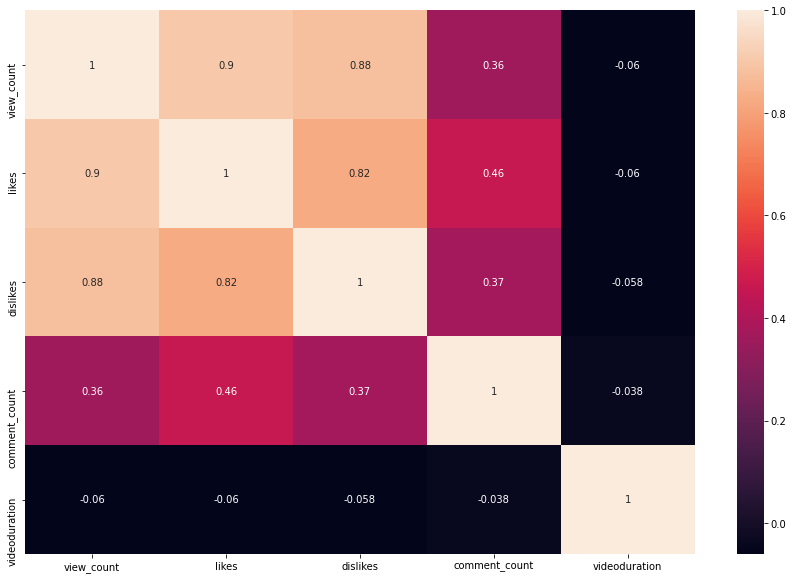

In [13]:
correlation_data=database_combined[['view_count','likes','dislikes','comment_count','videoduration']]
plt.figure(figsize=(15,10))
sns.heatmap(correlation_data.corr(),annot=True, cmap='rocket')
plt.show()

**Observation:**
1. From the above correlation matrix, we observe that as the number of likes on a video increases, more people view the video. We also observe a similar pattern of increased views, as the number of dislikes and comments count on a video increase.

2. It is also observed that as video duration increases, fewer viewers engage with the video. We can also see that as video duration increases, the number of likes and dislikes on a video are also negatively impacted. 

**Inferences:**

A video begins to trend as more people watch it. The view count threshold before trending is relative. Liking, Disliking, and commenting on a video increases activity and reach to potential users. Therefore, as the likes, dislikes, and comments on a video increase, its reachability to users also increases.

Psychologists suggest that the average human attention span is 20 minutes. However, for online videos, it seems to be about 60 seconds. Since most users prefer to leisurely scroll on Youtube, lengthy videos can hamper their experience. It would require paying attention to the content for a longer duration and remembering things to make sense of the content.
Apart from this, as the famous adage goes, 'Time is Money', most people watching the videos want to gauge the most information in a minimum amount of time. For example, students who are watching informational videos on Youtube prefer to watch short and crisp videos, which would enable them to understand the concepts well in a short period.





## When to Publish Video:
Here, we analyze the ideal time to publish a video based on the column `publishedAt` from the database.
- We do this by plotting a bar chart for the frequency of hours at which a video was published by storing it in a column, `hour_publishedAt`
- We identify the top 5 timings of when the video should be uploaded

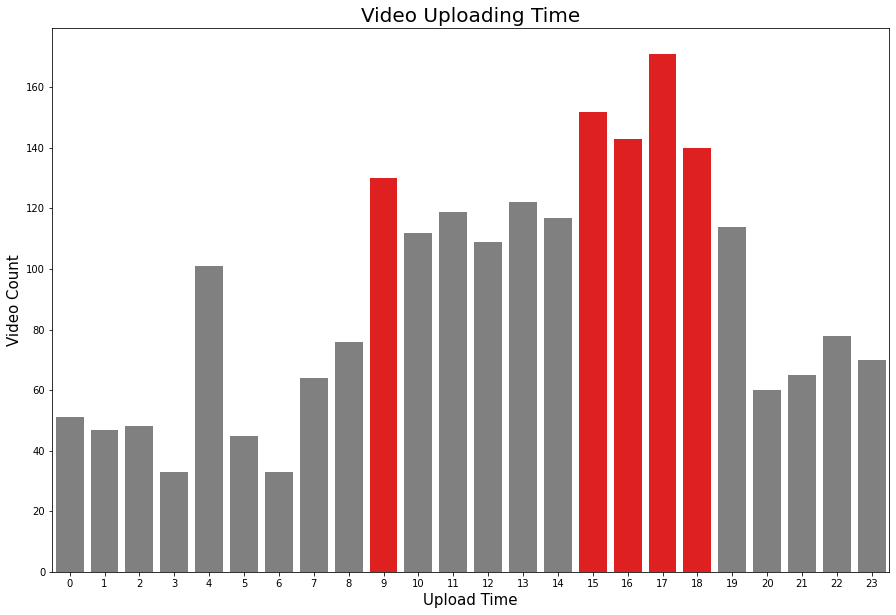

In [14]:
time_series_youtube_df = database_combined.set_index("publishedAt")
#get the hours of when its published
time_series_youtube_df["hour_publishedAt"] = time_series_youtube_df.index.hour
time_series_df = pd.DataFrame(time_series_youtube_df["hour_publishedAt"].value_counts()).sort_index()

#colour the top 5 values in descending order
red_clrs = time_series_df.sort_values(by="hour_publishedAt",ascending=False)[:5].index.tolist()
clrs = ["grey" if x not in red_clrs else "red" for x in time_series_df.index]
plt.figure(figsize=(15,10))

#plot the barchart with coloured bars
ax = sns.barplot(x=time_series_df.index,y=time_series_df["hour_publishedAt"], data=time_series_df, palette=clrs)
plt.ylabel("Video Count",fontsize=15)
plt.xlabel("Upload Time",fontsize=15)
plt.title("Video Uploading Time",fontsize=20)
plt.show()

<b>Observation</b>: From this, we can observe that the ideal time to upload a video would be in the morning at 9 am or in the evening from 3 pm to 6 pm.<br><br><b>Inference</b>: We can infer that the videos that are uploaded in the evening tend to trend more than any other time. This is because most of the crowd targeted at that time would be back home from school or work in the evening and want something to watch in order to relax at the end of the day. The anomaly for the 9:00 am is likely due to the videos being uploaded in other countries, primarily India, as it would be 7:00 pm that time.

## Sentiment Analysis
- We picked only 3 English-speaking countries, where English is the primary language for sentiment analysis. This was because the google translate library can't be heavily used to translate all languages to one.
- We then proceed with the sentiment analysis of the tags
- For this, we are using the SentimentIntensityAnalyzer, which will analyze each word in the tag and give us a calculated compound score
- We chose the most common 1000 words for better processing speeds as processing all words would be a performance-intensive task.
- We do the following processing on the data
    - Removing stop words
    - Removing digits
    - Removing special characters
    - Removing words with length more than 2
    - Perform Lemmatization for better results
    - Execute the frequency distribution to get 1000 most common words
    - Run the SentimentAnalyzer on each word<br>
- We choose the Vader for sentiment analysis as it uses lexical features which are labeled as positive or negative according to their semantic orientation to calculate the text sentiment
- Vader is also optimized for social media data and can yield good results.

In [15]:
#selecting english speaking countries
country_filter = ['US','GB','CA']
database_combined[database_combined["Country Code"].isin(country_filter)]

#Creating DataFrame for Sentiment Analysis for Tag
sentiment_polarity_df = database_combined[(database_combined["Country Code"].isin(country_filter))&(database_combined["tags"].notnull())]

def senti(x):
    '''This function returns the compound score using positive negative and neutral polarities'''
    return SentimentIntensityAnalyzer().polarity_scores(x)["compound"] 


#storing the stop words to remove later
stopwords_english = list(stopwords.words('english'))

# Lemmatizataion
lmtzr = WordNetLemmatizer()
categorywise_polairty_total = []
for item in video_categories_mapping:
    tagged_words = sentiment_polarity_df[sentiment_polarity_df["categoryId"]==item]["tags"].str.lower().str.cat(sep=' ')
    
    token_words = word_tokenize(re.sub('[^A-Za-z]+',' ',tagged_words))
    tagged_words_only = np.array([lmtzr.lemmatize(word) for word in token_words if((word not in stopwords_english)&(not word.isdigit()))])
    filtered_words = filter(lambda x : len(x)>2,tagged_words_only)    
    scores_total = pd.DataFrame(FreqDist(Text(list(filtered_words))).most_common(1000),columns=["Word","Freq"])["Word"].map(senti).sum()
    categorywise_polairty_total.append(scores_total)

categorywise_polairty_total_df = pd.DataFrame(categorywise_polairty_total)
category_name_df = pd.DataFrame(video_categories_mapping.values())
final_category_tags_df = pd.concat([category_name_df,categorywise_polairty_total_df],axis=1)
final_category_tags_df.columns=["Categories","Polarity"]
final_category_tags_df_new = final_category_tags_df[final_category_tags_df["Polarity"]!=0].sort_values(by="Polarity",ascending=False)



### Plotting the Polarities for Tags

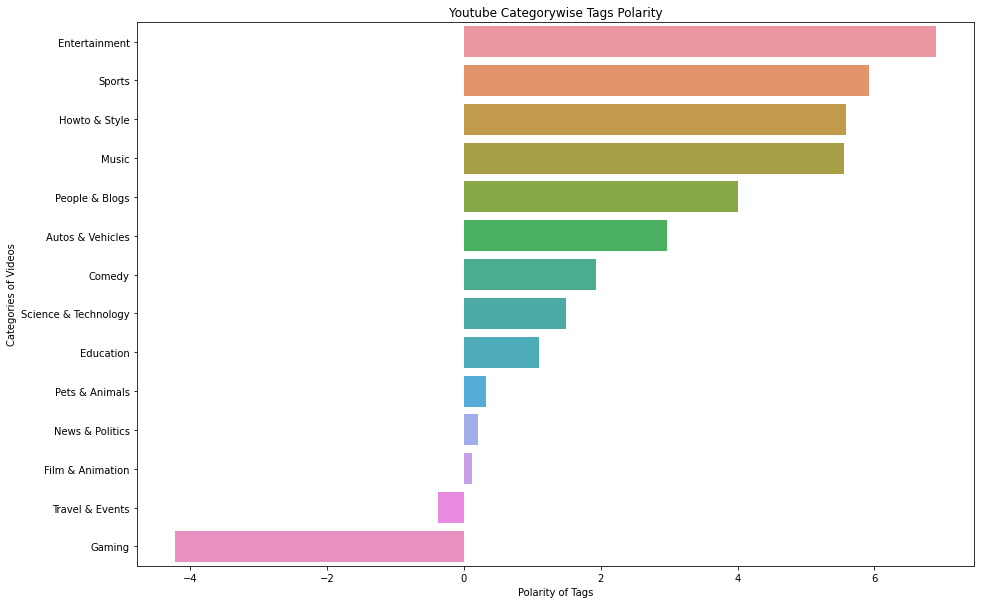

In [16]:
plt.figure(figsize=(15,10))
ax = sns.barplot(x=final_category_tags_df_new["Polarity"],y=final_category_tags_df_new["Categories"], data=final_category_tags_df_new,orient="h")
plt.ylabel("Categories of Videos")
plt.xlabel("Polarity of Tags")
plt.title("Youtube Categorywise Tags Polarity")
plt.show()

In [17]:
sentiment_polarity_df[sentiment_polarity_df["categoryId"]==20]["tags"].str.lower().str.cat(sep=' ')

"hermitcraft pranks-hermitcraft pranks and traps-hermitcraft season 8 pranks-tango tek-tango hermitcraft 8 lachlan lachy fortnite battle royale pubg battlegrounds-fortnite battle royale-fortnite-lachlan-lachy-duos-season 10-season x-new season-battle royal-lacy-laclan-epic games-gaming-esports-games-video games minecraft-mine craft-minecraft youtuber-pg-family friendly-skeppy-minecraft skeppy-no swearing-no cursing-minecraft trolling-minecraft troll-funny minecraft-minecraft mod-minecraft map-parkour-trolling-troll-roleplay-custom-challenge-glitch moments-skeppy face-try not to laugh-bedwars-skywars-hypixel-dream smp-race to beat minecraft vs badboyhalo-race to beat minecraft-badboyhalo-badboyhalo troll sallyisadog-sallyisadogshorts-sallyisadogbullfrog-sallyisadogwarzone-sallyisadogskin-sallyisadogtiktok-sallyisadogage-sallyisadogrealname-sallyisadogjob-sallyisadogm4-sallyisadogxm4-sallyisadogtwitch-sallyisadogmp5-sallyisadogkilo-sallyisadogamax-sallyisadogak47-sallyisadogmac10-sallyis

In [18]:
video_categories_mapping

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 29: 'Nonprofits & Activism',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In [19]:
final_category_tags_df_new

Categories  Polarity
11         Entertainment    6.8966
4                 Sports    5.9199
13         Howto & Style    5.5789
2                  Music    5.5584
9         People & Blogs    4.0119
1       Autos & Vehicles    2.9726
10                Comedy    1.9357
15  Science & Technology    1.4975
14             Education    1.0940
3         Pets & Animals    0.3216
12       News & Politics    0.2023
0       Film & Animation    0.1164
6        Travel & Events   -0.3730
7                 Gaming   -4.2230

**Observation**: We can see that categories like Entertainment Sports and Howto & Style and Music have  high positive polarity scores. Meanwhile, categories like Gaming, Travel & Events, Film & animation, and News&Politics have low or negative polarity scores.

**Inference**: We can infer from this that if we want our videos to be trending among categories like Entertainment, Howto & Style, and Music, we would need to use tag words that have a positive polarity and similarly for the videos to be trending in other categories the YouTuber can use negative polarity words for categories like Gaming, Travel & Events, Film & Animation and News & Politics. Since news and politics are related, their videos generally have a negative trend. It is also not surprising to see gaming having a negative trend since gamers keep using negative polarity words to make content like "pranks" or "battle" that provide strong negative polarity.

## WordCloud for MusicTitle:
To further analyze what Title words are generally trending, we can create a word cloud and check the most common terms that pop up.
- We do word processing as done previously, but we don't run the SentimentAnalyzer

In [20]:
# masking Youtubes logo to the wordcloud for the theme

mask_image = imageio.imread('youtube_logo.png')
tagged_words = database_combined[database_combined["categoryId"]==26]["tags"].str.lower().str.cat(sep=' ')
token_words = word_tokenize(re.sub('[^A-Za-z]+',' ',tagged_words))
tagged_words_only = np.array([lmtzr.lemmatize(word) for word in token_words if((word not in stopwords_english)&(not word.isdigit()))])
filtered_words = filter(lambda x : len(x)>2,tagged_words_only)    
filtered_words = list(filtered_words)




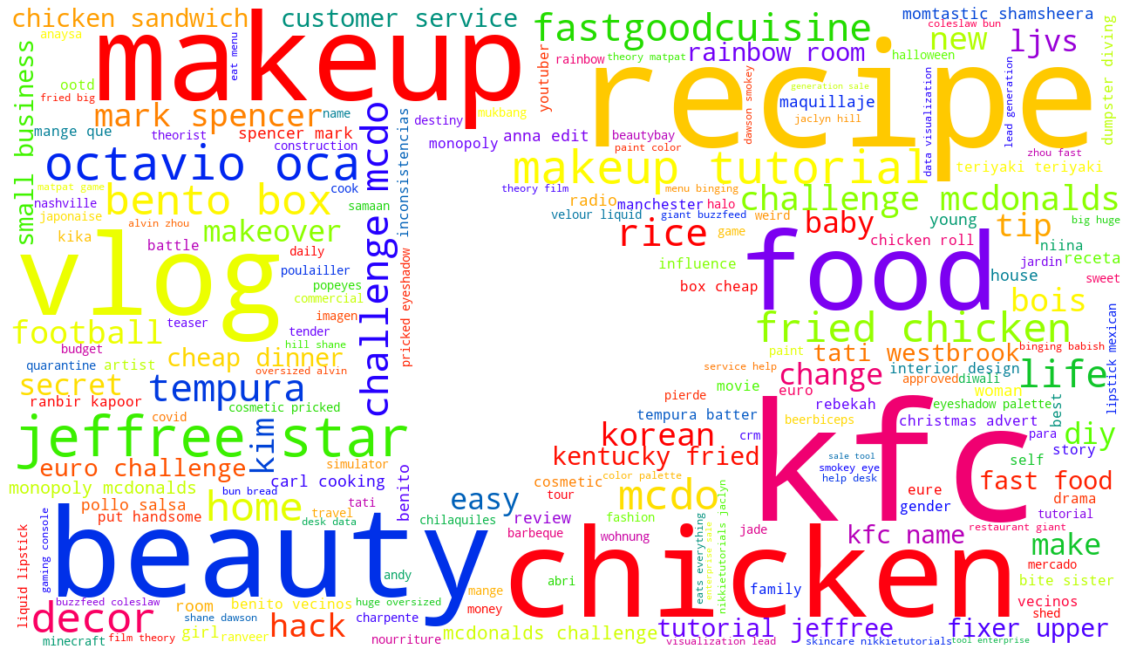

In [21]:
notuseful_words = ["official","music","video","short","highlights","highlight","trailer","audio","oficial"]
new_words = list(filter(lambda w: w not in notuseful_words, filtered_words))
plt.figure(figsize=(20,15))
title_cloud = WordCloud(colormap='prism',mask=mask_image,background_color="white")
title_cloud = title_cloud.generate(' '.join(new_words))
plt.imshow(title_cloud,interpolation="bilinear")
plt.axis("off")
plt.show()

**Observation:** 

We can notice that apart from the words official, video and music, etc we see that Travis Scott comes up many times along with Mariah Carey as Christmas is coming and her song is starting to trend more now and also Bruno Mars has released a new song Silk Sonic. Travis Scott has come up many times in music not just because of his music but also since there was an incident at his concert which lead to the trend, unfortunately.

## Top Videos in the Data Set:
Here we try to see the top videos present in our dataset in general. Since, we have also captured the thumbnail link, we decided to show it.

In [22]:
def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
    '''

    return '<img src="'+ path + '" style=max-height:124px;"/>'

#get the top 10 video based on frequency
top_videos_df = database_combined[database_combined["video_id"].isin(database_combined["video_id"].value_counts()[:10].index.tolist())][["thumbnail_link","title","channelTitle","video_id","view_count","categoryId"]]
top_videos_df = top_videos_df.astype({"video_id": str})
top_videos_df = top_videos_df.drop_duplicates(subset = ["video_id"]).reset_index(drop=True)
top_videos_df["CategoryName"] = top_videos_df["categoryId"].map(video_categories_mapping)
#show the dataframe with thumbnail
HTML(top_videos_df[["thumbnail_link","title","channelTitle","view_count","CategoryName"]].to_html(index=False,escape=False ,formatters=dict(thumbnail_link=path_to_image_html)))

**Observation:** 

We noticed that most YouTube viewers like to watch music content by Bruno Mars, Travis Scott, Mariah Carey (Christmas song). They also prefer to watch gaming content like Ozymandias and ELDEN RING - Gameplay Preview.

# Impact of Video Duration and Globalization : 
### What are the most viewed videos in different countries？
- Now that we know which categories were most popular, let us find out which videos were topping the trending list by region
- To get a better idea of the global variances in trending videos, we look at the most popular videos across countries.

In [23]:
#determine the top viewd videos overall
top_by_most_views = database_combined.sort_values(by=['view_count'], ascending=False)
top_by_most_views = top_by_most_views[0:10]
top_by_most_views.head()

video_id                                              title  \
1231  TaDAJgw4SIQ  It ends brutally 😂 #thatlittlepuff #recipe #pu...   
1253  duH-t0oNuW8  primitive survival tool ये सबसे अलग है@Primiti...   
468   sJoTB3JjCZI  She was luckier! 😂 #shorts Best video by MoniLina   
701   s5RlOldpKwA                        When ur eating on the plane   
552   s5RlOldpKwA                        When ur eating on the plane   

                   publishedAt                 channelId  \
1231 2021-11-04 02:01:56+00:00  UClFN9LShD_Pv0wnSeUKbUZw   
1253 2021-11-01 09:28:31+00:00  UCafZRSFizZ_wIn3cTmKC3XA   
468  2021-11-04 07:00:15+00:00  UCFwOAy34fL31Im7_udynwvg   
701  2021-10-30 18:00:13+00:00  UC_k6e2PPDUnxEdMJC9Q044g   
552  2021-10-30 18:00:13+00:00  UC_k6e2PPDUnxEdMJC9Q044g   

                         channelTitle  categoryId  \
1231                 That Little Puff          22   
1253  P2 Motivation {Palkesh Rathore}          24   
468                          MoniLina          23   
701                            Adam W          23   
552                            Adam W          23   

                        trending_date  \
1231 2021-11-09 00:45:01.372066+00:00   
1253 2021-11-09 00:45:01.688556+00:00   
468  2021-11-09 00:45:05.260545+00:00   
701  2021-11-09 00:45:03.909005+00:00   
552  2021-11-09 00:45:06.190648+00:00   

                                                   tags  view_count    likes  \
1231                                                NaN    79101613  3756197   
1253  primitive survival tool-primitive survival too...    64315630  4925434   
468                                                 NaN    59775903  2149607   
701   AdamW-Adam Waheed-Sketch comedy-room1041-youtu...    57383482  4586166   
552   AdamW-Adam Waheed-Sketch comedy-room1041-youtu...    57383482  4586190   

      ...                                  thumbnail_link  comments_disabled  \
1231  ...  https://i.ytimg.com/vi/TaDAJgw4SIQ/default.jpg              False   
1253  ...  https://i.ytimg.com/vi/duH-t0oNuW8/default.jpg              False   
468   ...  https://i.ytimg.com/vi/sJoTB3JjCZI/default.jpg              False   
701   ...  https://i.ytimg.com/vi/s5RlOldpKwA/default.jpg              False   
552   ...  https://i.ytimg.com/vi/s5RlOldpKwA/default.jpg              False   

     ratings_disabled                                        description  \
1231            False                                                NaN   
1253            False  #shorts #youtubeshorts #p2motivation #amazing ...   
468             False  Thank you for watching our channel MoniLina!Pl...   
701             False  Subscribe Here for new #shorts:https://www.you...   
552             False  Subscribe Here for new #shorts:https://www.you...   

      videoresolution videoduration videoprojected  videoliscensed  \
1231               hd            27    rectangular            True   
1253               hd            33    rectangular           False   
468                hd            27    rectangular            True   
701                hd            60    rectangular           False   
552                hd            60    rectangular           False   

     Country Code          trendDuration  
1231           IN 4 days 22:43:05.372066  
1253           IN 7 days 15:16:30.688556  
468            CA 4 days 17:44:50.260545  
701            DE 9 days 06:44:50.909005  
552            CA 9 days 06:44:53.190648  

[5 rows x 22 columns]

In [24]:
#Determine the videos that were trending the longest
top_by_trend_duration = database_combined.sort_values(by=['trendDuration'], ascending=False)
top_by_trend_duration = top_by_trend_duration[0:10]
top_by_trend_duration.head(10)

video_id                                              title  \
1145  ZSMoo4s2YEA                  The Great Wall of Mansour Bahrami   
592   lcmn_PCabq8  Mark Bouquin. Handicapped underhand. Mark 21 p...   
1189  lcmn_PCabq8  Mark Bouquin. Handicapped underhand. Mark 21 p...   
594   RJvk9aezV8I              I'M GONNA WIN THE SQUID GAME! #shorts   
515   AWdXMX8BjEE               8 Year Old Pranks Father 🤣🤣🤣 #Shorts   
784   2J8Iz98sVIQ                                  The Squad #shorts   
440   OAihRxMtJ3o  Millionaires Are Broke (Compared To THIS) #shorts   
160   nLxmuh6wCVY  Highlights: Manchester United 0-5 Liverpool | ...   
1797  Avgj5ujkih8                             젖은 제티를 1초만에 가루로 바꾸는 방법   
433   WUorSAtPyu4                Kevin Gates x Dusa Dear God (Audio)   

                   publishedAt                 channelId    channelTitle  \
1145 2021-10-13 13:11:35+00:00  UCNa8NxMgSm7m4Ii9d4QGk1Q       Wimbledon   
592  2021-10-18 23:55:53+00:00  UCDFbRotHqLZIP_I06CrmSlQ    Mark Bouquin   
1189 2021-10-18 23:55:53+00:00  UCDFbRotHqLZIP_I06CrmSlQ    Mark Bouquin   
594  2021-10-22 04:46:10+00:00  UC49RUOWVmqhZrxCZPBMjC_A     ItsUncleSam   
515  2021-10-22 10:23:06+00:00  UCoGForHQAmk0_9rI9CABeYw  Woody & Kleiny   
784  2021-10-23 09:02:18+00:00  UCZ94byYZ5jP3fgVGQ-LTzXg   Memory Hunter   
440  2021-10-23 17:39:39+00:00  UCXl0djQ2IljcG-shgv-hIEA     Daniel Iles   
160  2021-10-24 21:06:53+00:00  UC9LQwHZoucFT94I2h6JOcjw    Liverpool FC   
1797 2021-10-26 08:15:58+00:00  UCl7MKZHz017uFK_gFrgD0sw            코코보라   
433  2021-10-26 15:53:11+00:00  UCj2GTFekdV3EUsTVN8oaEqA    kevingatesTV   

      categoryId                    trending_date  \
1145          17 2021-11-09 00:45:00.501286+00:00   
592           22 2021-11-09 00:45:06.192640+00:00   
1189          22 2021-11-09 00:45:00.971138+00:00   
594           20 2021-11-09 00:45:06.192640+00:00   
515           10 2021-11-09 00:45:05.835454+00:00   
784           20 2021-11-09 00:45:04.325733+00:00   
440           27 2021-11-09 00:45:04.779918+00:00   
160           17 2021-11-09 00:44:59.209327+00:00   
1797          24 2021-11-09 00:45:09.654534+00:00   
433           10 2021-11-09 00:45:04.779918+00:00   

                                                   tags  view_count    likes  \
1145  Tennis-Wimbledon-wimbledon championship-wimble...    11137679   257355   
592                                                 NaN    17112030  1101945   
1189                                                NaN    17108901  1101942   
594   Itsunclesam-1440p-comedy-commentary-funny game...    41086097  2464042   
515   shorts-viral-comedy-best friends-best of woody...    27870860  1383321   
784                                                 NaN     1053244    56286   
440                                                 NaN     3297745   238860   
160   Liverpool FC-LFC-Liverpool-Anfield-Melwood-Liv...    12143766   208412   
1797                                   코코아가루-제티-코코아가루방수     3008690    78180   
433   kevin gates-kevin-gates-atlantic-atlantic reco...     1777035    63744   

      ...                                  thumbnail_link  comments_disabled  \
1145  ...  https://i.ytimg.com/vi/ZSMoo4s2YEA/default.jpg              False   
592   ...  https://i.ytimg.com/vi/lcmn_PCabq8/default.jpg              False   
1189  ...  https://i.ytimg.com/vi/lcmn_PCabq8/default.jpg              False   
594   ...  https://i.ytimg.com/vi/RJvk9aezV8I/default.jpg              False   
515   ...  https://i.ytimg.com/vi/AWdXMX8BjEE/default.jpg              False   
784   ...  https://i.ytimg.com/vi/2J8Iz98sVIQ/default.jpg              False   
440   ...  https://i.ytimg.com/vi/OAihRxMtJ3o/default.jpg              False   
160   ...  https://i.ytimg.com/vi/nLxmuh6wCVY/default.jpg              False   
1797  ...  https://i.ytimg.com/vi/Avgj5ujkih8/default.jpg              False   
433   ...  https://i.ytimg.com/vi/WUorSAtPyu4/default.jpg              False   

     ratings_disabled            

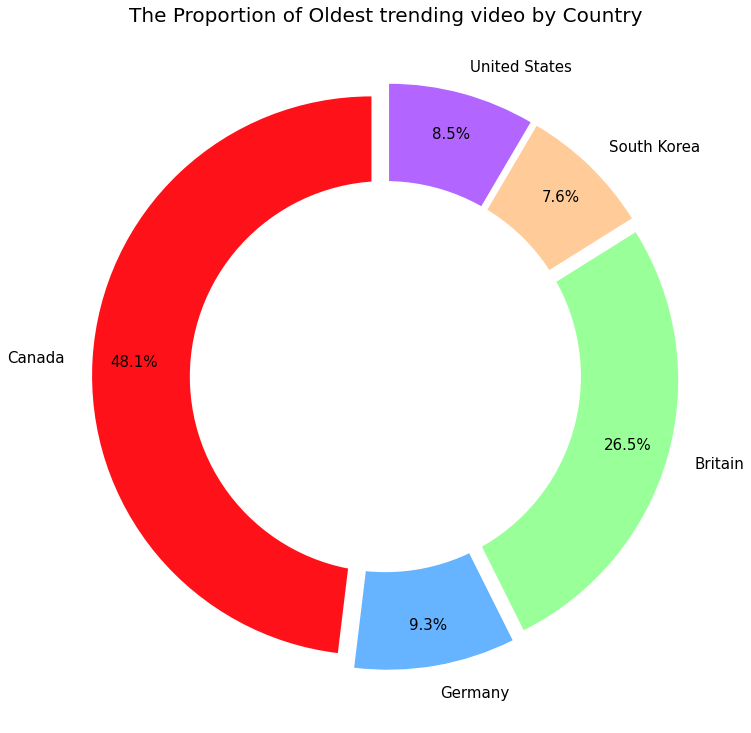

In [25]:
# Pie chart
top_by_trend_duration_sum = top_by_trend_duration.groupby('Country Code')['trendDuration'].sum()
sizes = top_by_trend_duration_sum.values.tolist()
labels = 'Canada', 'Germany','Britain', 'South Korea', 'United States'
#colors
colors = ['#ff1119','#66b3ff','#99ff99','#ffcc99','#B366FF']
#explsion
explode = (0.05,0.05,0.05,0.05,0.05)
plt.figure(figsize=(15,10))
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode,textprops={'fontsize': 15})
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()
plt.title("The Proportion of Oldest trending video by Country",fontsize=20)
plt.show()

#### Observation:
- The 'trendDuration' is the time between when the video was uploaded and when it made it to the trending list. Canada, Britain, South Korea, Germany, and the United States top the list of countries where videos take some time to trend.


# Geographical Impact:
Here we try to find any relevant trends in different categories by region. 

In [26]:
def get_top_category_row(df, country_code, cat_name_map, n=5):
    '''Return the list of top n trends for each country'''
    # grouping by categoryid to find trends in videos specific to category and returning top n rows
    result = (
        df.groupby('categoryId', as_index=False).size().sort_values(by='size', ascending=False).head(n)
    )
    
    #mapping the category id and category name so as to make sense what the ids actually mean
    result['categoryName'] = result['categoryId'].map(cat_name_map)
    return [country_code, *result['categoryName']]


test_list=[]
# Iterate through each country code and get the top 3 categories for each into a dataframe
for count_code in country_codes:
    test_list_itm = get_top_category_row(database_combined[database_combined["Country Code"]== count_code],count_code,video_categories_mapping)
    test_list.append(test_list_itm)

top_df = pd.DataFrame(test_list,columns=['Country', 'Top1', 'Top2', 'Top3','Top4', 'Top5'])
top_df

Country           Top1            Top2            Top3            Top4  \
0       US         Gaming   Entertainment           Music          Sports   
1       GB  Entertainment          Sports          Gaming           Music   
2       IN  Entertainment  People & Blogs           Music          Comedy   
3       DE  Entertainment           Music          Gaming  People & Blogs   
4       CA         Gaming   Entertainment           Music  People & Blogs   
5       FR  Entertainment          Gaming           Music          Comedy   
6       KR  Entertainment  People & Blogs           Music   Howto & Style   
7       RU         Gaming  People & Blogs   Entertainment          Comedy   
8       JP  Entertainment          Gaming           Music          Sports   
9       BR  Entertainment           Music  People & Blogs          Gaming   
10      MX  Entertainment           Music          Gaming          Sports   

               Top5  
0    People & Blogs  
1    People & Blogs  
2            Gaming  
3            Sports  
4            Sports  
5            Sports  
6            Sports  
7   News & Politics  
8    People & Blogs  
9            Sports  
10   People & Blogs

#### Compare US with Canada:

In [27]:
com_usca = top_df.iloc[0]
com_usca = pd.DataFrame(com_usca).rename(columns={0: "US"}).drop(['Country'])
com_usca['CA'] = top_df.iloc[4]
com_usca 

US              CA
Top1          Gaming          Gaming
Top2   Entertainment   Entertainment
Top3           Music           Music
Top4          Sports  People & Blogs
Top5  People & Blogs          Sports

#### Compare France with UK

In [27]:
com_gbfr = top_df.iloc[1]
com_gbfr = pd.DataFrame(com_gbfr).rename(columns={1: "GB"}).drop(['Country'])
com_gbfr['FR'] = top_df.iloc[5]
com_gbfr 

GB             FR
Top1   Entertainment  Entertainment
Top2          Sports         Gaming
Top3          Gaming          Music
Top4           Music         Comedy
Top5  People & Blogs         Sports

#### Compare Korea with Japan

In [28]:
com_krjp = top_df.iloc[6]
com_krjp = pd.DataFrame(com_krjp).rename(columns={6: "KR"}).drop(['Country'])
com_krjp['JP'] = top_df.iloc[8]

com_krjp

KR              JP
Top1   Entertainment   Entertainment
Top2  People & Blogs          Gaming
Top3           Music           Music
Top4   Howto & Style          Sports
Top5          Sports  People & Blogs

#### Observation: 
- US and CA have the similar kind of popular categories in the top 5, and they are both from North America. Thus, we can safely say that these countries are correlated as they have the same categories.
- Korea and Japan have different category preferences. Apart from these countries, Britain and France also have different preferences of trending video categories.

#### Inference:
- In this case, we analyzed countries by two variables: distance and language.
- France is relatively close to Britain, and Korea is reasonably close to Japan. However,  their historical and cultural architecture is different. Thus we may presume they have different watching preferences. Further analysis needs to be done in this domain.
- When we analyzed the countries US and Canada, we noticed that they are contiguous and speak the same language. This pattern could be because U.S and Canada share similar cultures and languages. However, there are some videos and channels that defy this generalization. An interesting example is a popular band like BTS. Even though their content is non-English, their videos are watched globally. Hence, this analysis cannot be generalized entirely.
- Thus, further analysis is needed to make any such conclusions.


## Impact of Economics:

### YouTube trending videos with respect to region: Impact based on the Economic Status
We try to analyze the different preferences for different video categories based on the Economic Status

We've categorized the countries into two groups - Developing and Developed Countries based on the Economic status.
According to the World Population Review, there are several factors determine whether or not a country is developed, such as its political stability, gross domestic product (GDP), level of industrialization, social welfare programs, infrastructure, and the freedom that its citizens enjoy.



In [29]:
# Set up necessary variables
country_start=0
country_end=7

#Generate numpy list which contains categories from developed and developing countries 
developed_list=['US','GB','DE','CA','FR','KR','JP']
developing_list=['IN','RU','BR','MX']
developed = top_df[top_df['Country'].str.contains('|'.join(developed_list))].drop(columns='Country').to_numpy()  
developing=top_df[top_df['Country'].str.contains('|'.join(developing_list))].drop(columns='Country').to_numpy()

# Count categories
developed_final=np.concatenate(developed[country_start:country_end])
developing_final=np.concatenate(developing[country_start:country_end])
developed_cate,developed_count=np.unique(developed_final,return_counts=True)
developing_cate,developing_count=np.unique(developing_final,return_counts=True)

# Generate the barchart shows comparision of two groups 
cate_name=developed_cate
fig = go.Figure(data=[
    go.Bar(name='Developed countries', x=cate_name, y=developed_count/sum(developed_count)*100),
    go.Bar(name='Developing countries', x=cate_name, y=developing_count/sum(developing_count)*100)
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

In [32]:
def get_channel(channel_name):
    return yt.search().list(q=channel_name,type="channel",part="id,snippet").execute()


def get_videos(channel_id,part="id,snippet",limit=10):
    res = yt.channels().list(id=channel_id,part="contentDetails").execute()
    playlist_id = yt.channels().list(id=channel_id,part="contentDetails").execute()["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
    videos=[]
    next_page_token = None
    while 1:
        res = yt.playlistItems().list(playlistId=playlist_id, part= part,maxResults=min(limit,50),pageToken=next_page_token).execute()
        
        videos+=res["items"]
        next_page_token = res.get("nextPageToken")
        
        if next_page_token is None or len(videos) >=limit:
            break
    return videos
    
    
def parse_publish_timestamp(video,changehours=0,changeminutes=0):
    return (dt.datetime.strptime(video["snippet"]["publishedAt"],"%Y-%m-%dT%H:%M:%SZ")+dt.timedelta(hours=changehours,minutes=changeminutes))

In [33]:
channel_Id_piewdiepiew = get_channel("pewdiepie")["items"][0]["id"]["channelId"]
channel_Id_tseries = get_channel("t-series")["items"][0]["id"]["channelId"]

videos_piewdie = get_videos(channel_Id_piewdiepiew,limit=50)
videos_tseries = get_videos(channel_Id_tseries,limit=50)

publish_timestamp_piewdie = [parse_publish_timestamp(video,changehours=1) for video in videos_piewdie]
publish_timestamp_t_series = [parse_publish_timestamp(video,changehours=5,changeminutes=30) for video in videos_tseries]

publish_time_only_piewdie = [t.hour + t.minute/60 for t in publish_timestamp_piewdie]
publish_time_only_t_series = [t.hour + t.minute/60 for t in publish_timestamp_t_series]

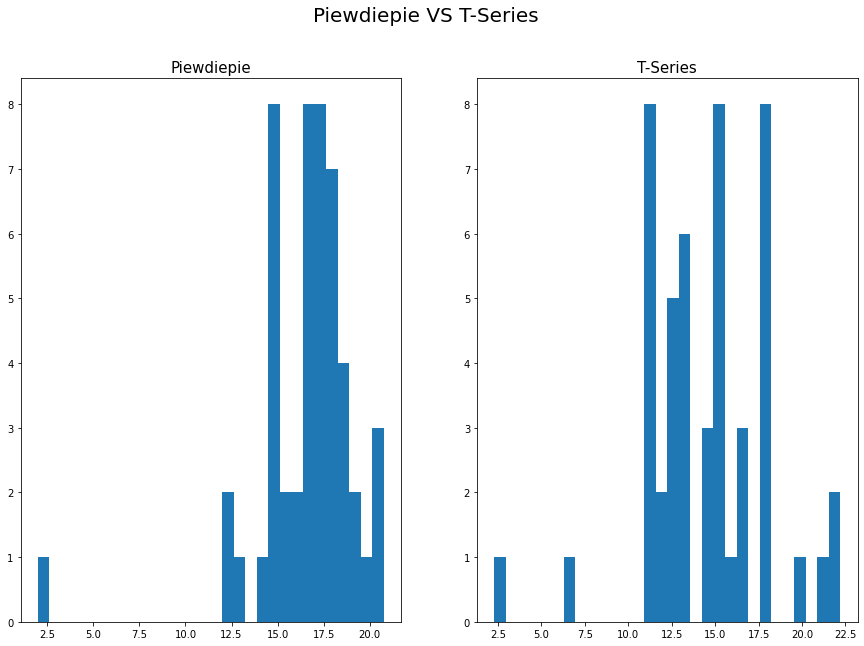

In [34]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.hist(publish_time_only_piewdie,bins=30)
plt.title("Piewdiepie",fontsize=15)
plt.subplot(1,2,2)
plt.hist(publish_time_only_t_series,bins=30)
plt.title("T-Series",fontsize=15)

plt.suptitle('Piewdiepie VS T-Series',fontsize=20)
plt.show()

#### Observation:

- We can observe that among 24 Video categories, 7 categories are the most popular -containing the most trending videos across both the Developed and Developing Countries.
- The most popular category among both these groups is **Entertainment**. This is closely followed by **Gaming** and **People & Blogs** as there's not much considerable difference in the proportion of choice. 
- On comparing the other four categories, we notice the difference in preference between developed and developing countries. For instance, developing countries prefer to watch **Comedy** and **Howto & Style** videos more than developed countries. In contrast, the developed countries like to watch **Music** and **Sports** videos.


#### Business Value

- Content creators with target audience from developing countries could improve their revenue and attract more viewers by bundling content of **Comedy**,**Howto & Style**, **Music** and **Sports** from both groups. For example, we can invite NBA players to do Roast Shows, this would combine both **Comedy** and **Sports** feature, making the video enjoyable to viewers of both the groups. Another example is to make videos about teaching "how to play guitar", this is a combination of *Howto & Style* and *Music*.
- Furthermore, content creators targeting first group of categories-preferred by devloping countries, might have to consider lowering their "Join the Channel" fee and can leverage the volume because of higher population present in the developing countries.

# Conclusion:
With our analysis potential youtubers and content creators can gain insights on what factors to account for, while aiming to make their videos trend. 
<br>Key takeaways from the Analysis:

- Bundle the content from different categories preferred by different economic groups(developed and developing countries), as this would attract both groups of users.
- Content Creators targeting  Entertainment, How to & Style, and Music can use tags with positive polarity. When posting in other categories like Gaming, Travel & Events, Film & Animation, and News & Politics could use negative polarity words.
- The videos uploaded in the evening tend to trend more than any other time. 
- Liking, Disliking, and commenting on a video increases activity and reach to potential users.
- The longer a video, the less likely it is to end up on the trending list


All these factors are some of the key ingredients to make your delicious Pie(y)-Tube.

# References:

- YouTube API:
    - [google api doc](https://developers.google.com/youtube/v3/docs) <br>
    - [google api python client github](https://googleapis.github.io/google-api-python-client/docs/dyn/youtube_v3.html)  <br>
    - [GitHub Youtube Api](https://github.com/googleapis/google-api-python-client/blob/main/docs/dyn/index.md) <br>
    - Mitchell Jolly.( Oct 31, 2018). *Trending-YouTube-Scraper* [GitHub](https://github.com/mitchelljy/Trending-YouTube-Scraper/blob/master/scraper.py)<br>
<br>
- Impact of Views: 
    - [Wistia](https://wistia.com/learn/marketing/4-ways-to-keep-viewers-engaged-in-an-online-video)
- Impact of Econoics:
    - Refrence: https://worldpopulationreview.com/country-rankings/developed-countries, https://worldpopulationreview.com/country-rankings/developing-countries.


